# `DAG`
- circuit in quafu to dag
- dag visualization briefly
- dag to circuit in quafu

In [1]:
import numpy as np
from quafu import User,QuantumCircuit,Task ,simulate
import quafu
import networkx as nx
from typing import Dict, Any, List

 you should install `pygraphviz` ,`pydot` package  for visualization    
 `pip install pygraphviz `    
 `pip install pydot`


In [2]:
import pygraphviz as pgv
from networkx.drawing.nx_pydot import write_dot

In [3]:
from networkx import MultiDiGraph

In [4]:
# user = User()
# # user.save_apitoken("<your API token>")

In [5]:
# task = Task()
# task.config(backend="ScQ-P18", shots=2000, compile=True)

In [6]:
from typing import Dict, Any, List, Union
import dataclasses

@dataclasses.dataclass
class InstructionNode: 
    name:Any            # gate.name
    pos:Union[List[Any], Dict[Any,Any]]       # gate.pos |  Dict[Any,Any] for measure
    paras:List[Any]        # gate.paras
    # matrix:List[Any]   # for gate in [QuantumGate]
    duration:Union[int,float]      # for gate in [Delay,XYResonance] in quafu 
    unit:str           # for gate in [Delay,XYResonance] in quafu
    label:str
        
    def __hash__(self):
        return hash((type(self.name), tuple(self.pos) ,self.label))
    
    def __str__(self):
        if self.name == 'measure':
            args = ','.join(str(q) for q in self.pos.keys())
            args += f'=>{",".join(str(c) for c in self.pos.values())}'
        else:    
            args = ','.join(str(q) for q in self.pos)
            
        if self.paras == None:
            return f'{self.label}{{{self.name}({args})}}'
        else:
            # if self.paras not a list, then make it a list  of str of .3f float
            if not isinstance(self.paras, list):
                formatted_paras = [f'{self.paras:.3f}']
            else:
                formatted_paras = [f'{p:.3f}' for p in self.paras]  
                
            formatted_paras_str = ','.join(formatted_paras)
            
            return f'{self.label}{{{self.name}({args})}}({formatted_paras_str})'
    
    def __repr__(self): 
        return str(self)

## dagcircuit class

In [7]:
import networkx as nx

from networkx.classes.multidigraph import MultiDiGraph

class DAGCircuit(MultiDiGraph):
    def __init__(self,qubits_used=None, cbits_used=None, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)
              
        if qubits_used is None:
            self.qubits_used = set()
        elif isinstance(qubits_used, set):
            self.qubits_used = qubits_used
        else:
            raise ValueError('qubits_used should be a set or None')

        if cbits_used is None:
            self.cbits_used = set()
        elif isinstance(cbits_used, set):
            self.cbits_used = cbits_used
        else:
            raise ValueError('cbits_used should be a set or None')
        
        # num of instruction nodes
        self.num_instruction_nodes = 0


    # add new methods or override existing methods here.

    def update_qubits_used(self):
        '''
        qubits_used is a set of qubits used in DAGCircuit
        based on node -1's edges' labels, the qubits is the integer part of the label

        return:
            qubits_used: set of qubits used in DAGCircuit
        '''
        if -1 not in self.nodes:
            raise ValueError('-1 should be in DAGCircuit, please add it first')
        self.qubits_used = set([int(edge[2]['label'][1:]) for edge in self.out_edges(-1, data=True)])
        return self.qubits_used
    
    def update_cbits_used(self):
        '''
        cbits_used is a set of cbits used in DAGCircuit
        calculated by  measurenode's cbits        
        return:
            cbits_used: set of cbits used in DAGCircuit
        '''
        for node in self.nodes:
        # if node.has a attribute 'name' and node.name == 'measure'
            if hasattr(node, 'name') and node.name == 'measure':
                self.cbits_used = set(node.pos.values())   
        return self.cbits_used
    
    def update_num_instruction_nodes(self):
        '''
        num_instruction_nodes is the number of instruction nodes in DAGCircuit
        '''
        if -1 not in self.nodes:
            raise ValueError('-1 should be in DAGCircuit, please add it first')
        if float('inf') not in self.nodes:
            raise ValueError('float("inf") should be in DAGCircuit, please add it first')
        self.num_instruction_nodes = len(self.nodes) - 2

        for node in self.nodes:
            if hasattr(node, 'name') and node.name == 'measure':
                self.num_instruction_nodes -= 1
        return self.num_instruction_nodes

    

    def nodes_dict(self):
        '''
        nodes_dict is a dictionary of nodes with the node label as key and the node as value.
        without  -1 and float('inf')
        '''
        nodes_dict = {}
        for node in self.nodes:
            if node != -1 and node != float('inf'):
                nodes_dict[node.label] = node
        return nodes_dict
     

    def nodes_list(self):
        ''' 
        nodes_list is a list of nodes without  -1 and float('inf')
        ''' 
        nodes_list = []
        for node in self.nodes:
            if node != -1 and node != float('inf'):
                nodes_list.append(node)
        return nodes_list
    
    def node_qubits_predecessors(self, node:InstructionNode):
        '''
        node_qubits_predecessors is a dict of {qubits -> predecessors }of node
        Args:
            node in DAGCircuit, node should not be -1
        Returns:
            node_qubits_predecessors: dict of {qubits -> predecessors }of node
        '''
        # for edge in self.in_edges(node, data=True):
        #     print(edge[0], edge[1], edge[2])

        if node not in self.nodes:
            raise ValueError('node should be in DAGCircuit')
        if node in [-1]:
            raise ValueError('-1 has no predecessors')

        predecessor_nodes = [edge[0] for edge in self.in_edges(node, data=True)]
        qubits_labels = [int(edge[2]['label'][1:]) for edge in self.in_edges(node, data=True)]
        node_qubits_predecessors = dict(zip(qubits_labels, predecessor_nodes))
        return node_qubits_predecessors
    
    def node_qubits_successors(self, node:InstructionNode):
        '''
        node_qubits_successors is a dict of {qubits -> successors }of node
        Args: 
            node in DAGCircuit, node should not be  float('inf')
        Returns:
            node_qubits_successors: dict of {qubits -> successors }of node


        '''
        if node not in self.nodes:
            raise ValueError('node should be in DAGCircuit')
        if node in [float('inf')]:
            raise ValueError('float("inf") has no successors')
        successor_nodes = [edge[1] for edge in self.out_edges(node, data=True)]
        qubits_labels = [int(edge[2]['label'][1:]) for edge in self.out_edges(node, data=True)]
        node_qubits_successors = dict(zip(qubits_labels, successor_nodes))
        return node_qubits_successors

    def node_qubits_inedges(self, node:InstructionNode):
        '''
        node_qubits_inedges is a dict of {qubits -> inedges }of node
        Args:
            node in DAGCircuit, node should not be -1
        Returns:
            node_qubits_inedges: dict of {qubits -> inedges }of node
        '''
        if node not in self.nodes:
            raise ValueError('node should be in DAGCircuit')
        if node in [-1]:
            raise ValueError('-1 has no predecessors')

        inedges = [edge for edge in self.in_edges(node)]
        qubits_labels = [int(edge[2]['label'][1:]) for edge in self.in_edges(node, data=True)]
        node_qubits_inedges = dict(zip(qubits_labels, inedges))
        return node_qubits_inedges
    
    def node_qubits_outedges(self, node:InstructionNode):
        '''
        node_qubits_outedges is a dict of {qubits -> outedges }of node
        Args:
            node in DAGCircuit, node should not be float('inf')
        Returns:
            node_qubits_outedges: dict of {qubits -> outedges }of node
        '''
        if node not in self.nodes:
            raise ValueError('node should be in DAGCircuit')
        if node in [float('inf')]:
            raise ValueError('float("inf") has no successors')
        outedges = [edge for edge in self.out_edges(node)]
        qubits_labels = [int(edge[2]['label'][1:]) for edge in self.out_edges(node, data=True)]
        node_qubits_outedges = dict(zip(qubits_labels, outedges))
        return node_qubits_outedges
    
    def remove_instruction_node(self, gate:InstructionNode):
        '''
        remove a gate from DAGCircuit, and all edges connected to it.
        add new edges about qubits of removed gate between all predecessors and successors of removed gate.
        Args:
            gate: InstructionNode, gate should be in DAGCircuit, gate should not be -1 or float('inf')
        '''

        if gate not in self.nodes:
            raise ValueError('gate should be in DAGCircuit')
        if gate in [-1, float('inf')]:
            raise ValueError('gate should not be -1 or float("inf")')

        qubits_predecessors = self.node_qubits_predecessors(gate)
        qubits_successors = self.node_qubits_successors(gate)
        for qubit in gate.pos:
            if qubits_predecessors[qubit] != -1 and qubits_successors[qubit] != float('inf'):
                self.add_edge(qubits_predecessors[qubit], qubits_successors[qubit], label=f'q{qubit}')
            elif qubits_predecessors[qubit] == -1 and qubits_successors[qubit] != float('inf'):
                self.add_edge(qubits_predecessors[qubit], qubits_successors[qubit], label=f'q{qubit}',color='green')
            else:
                self.add_edge(qubits_predecessors[qubit], qubits_successors[qubit], label=f'q{qubit}',color='red')

        self.remove_node(gate)

        # update qubits
        self.qubits_used = self.update_qubits_used()


    def merge_dag(self, other_dag):
        '''
        merge other_dag into self
        Args:
            other_dag: DAGCircuit
        Returns:
            self: DAGCircuit
        '''
        if not isinstance(other_dag, DAGCircuit):
            raise ValueError('other_dag should be a DAGCircuit')
        if other_dag == None:
            return self
        if self == None:
            return other_dag
        
        # for the same qubits (intersection), 
        # remove the outgoing edges from the final node of the original DAG and the incoming edges from the initial node of the other DAG,
        # then connect the corresponding tail and head nodes by adding edges
        other_dag_qubits_used = other_dag.update_qubits_used()
        self_qubits_used = self.update_qubits_used()

        insect_qubits = self_qubits_used & other_dag_qubits_used
        end_edges_labels_1 = self.node_qubits_inedges(float('inf'))
        start_edges_labels_2 = other_dag.node_qubits_outedges(-1)

        if len(insect_qubits) != 0:
            for insect_qubit in insect_qubits:
                self.remove_edges_from([end_edges_labels_1[insect_qubit]])
                other_dag.remove_edges_from([start_edges_labels_2[insect_qubit]])
                self.add_edge(end_edges_labels_1[insect_qubit][0], start_edges_labels_2[insect_qubit][1], label=f'q{insect_qubit}')
        
        # add other_dag's nodes and edges into self
        # ！if we add edges, we don't need to add nodes again
        self.add_edges_from(other_dag.edges(data=True))

        # remove the edges between -1 and float('inf')
        self.remove_edges_from([edge for edge in self.edges(data=True) if edge[0] == -1 and edge[1] == float('inf')])
 
        # update qubits 
        self.qubits_used = self.update_qubits_used()
  
    def add_instruction_node(self, gate:InstructionNode,predecessors_dict:Dict[int,InstructionNode],successors_dict:Dict[int,InstructionNode]):
        '''
        add a gate into DAGCircuit, and all edges connected to it.
        add new edges about qubits of new gate between all predecessors and successors of new gate.
        Args:
            gate: InstructionNode, gate should not be -1 or float('inf')
            predecessors_dict: dict of {qubits -> predecessors }of gate
            successors_dict: dict of {qubits -> successors }of gate
        '''
        if gate in [-1, float('inf')]:
            raise ValueError('gate should not be -1 or float("inf")')
        
        #remove the edges between the predessors,successors about the qubits used by the added node
        qubits_pre_out_edges = []
        qubits_suc_in_edges = []
        for qubit in gate.pos:
            pre_out_edges = self.node_qubits_outedges(predecessors_dict[qubit])
            qubits_pre_out_edges.append(pre_out_edges[qubit])

            suc_in_edges = self.node_qubits_inedges(successors_dict[qubit])
            qubits_suc_in_edges.append(suc_in_edges[qubit])

        self.remove_edges_from(qubits_pre_out_edges)
        self.remove_edges_from(qubits_suc_in_edges)

        # add the new node and edges
        for qubit in gate.pos:
            if predecessors_dict[qubit] == -1:
                self.add_edge(predecessors_dict[qubit], gate, label=f'q{qubit}',color='green')
            else:
                self.add_edge(predecessors_dict[qubit], gate, label=f'q{qubit}')
            if successors_dict[qubit] == float('inf'):
                self.add_edge(gate, successors_dict[qubit], label=f'q{qubit}',color='red')
            else:
                self.add_edge(gate, successors_dict[qubit], label=f'q{qubit}')

        # update qubits
        self.qubits_used = self.update_qubits_used()


    def is_dag(self):
        '''
        is_dag is a bool value to check if DAGCircuit is a DAG
        '''
        return nx.is_directed_acyclic_graph(self)


In [8]:
import numpy as np
from quafu import QuantumCircuit

from quafu.elements.element_gates import * 
from quafu.elements.quantum_element import Barrier, Delay, ControlledGate, MultiQubitGate, ParaMultiQubitGate, QuantumGate, SingleQubitGate, XYResonance

import networkx as nx
from typing import Dict, Any, List, Union
import copy

# from instruction_node import InstructionNode  #  instruction_node.py in the same folder as circuit_dag.py now

# import pygraphviz as pgv
from networkx.drawing.nx_pydot import write_dot
from IPython.display import Image, SVG



# transform a gate in quantumcircuit of quafu(not include measure_gate),
# into a node in the graph, with specific label.
def gate_to_node(input_gate,specific_label: str):
    ''' 
    transform a gate in quantumcircuit of quafu(not include measure_gate),
    into a node in the graph, with specific label.

    Args:
        inputgate: a gate in quantumcircuit of quafu(not include measure_gate)
        label: the label of the node in the graph

    Returns:
        node: a node in the graph, with specific label. A GateWrapper object
    
    '''

    import copy
    gate = copy.deepcopy(input_gate) # avoid modifying the original gate
    if not isinstance(gate.pos, list):  # if gate.pos is not a list, make it a list
        gate.pos = [gate.pos]

    # use getattr check 'paras' and other attributes if exist. if the attr doesn't exist,return None
    gate.paras = getattr(gate, 'paras', None) or None
    gate.duration = getattr(gate, 'duration', None) or None
    gate.unit = getattr(gate, 'unit', None) or None 

    if gate.paras and not isinstance(gate.paras, list):  # if paras is True and not a list, make it a list
        gate.paras = [gate.paras]
    
    # hashable_gate = InstructionNode(gate.name, gate.pos, gate.paras,gate.matrix,gate.duration,gate.unit, label=i)
    hashable_gate = InstructionNode(gate.name, gate.pos, gate.paras,gate.duration,gate.unit, label=specific_label)
    return hashable_gate


# Building a DAG Graph using NetworkX from a QuantumCircuit
def circuit_to_dag(circuit,measure_flag = True):
    '''
    Building a DAG Graph using NetworkX from a QuantumCircuit
    
    Args:
        circuit: a QuantumCircuit object
        
    Returns:
        g: a networkx MultiDiGraph object
        
    example:
        .. jupyter-execute::
        
            from circuit_dag import circuit_to_dag, dag_to_circuit, draw_dag
            from quafu import QuantumCircuit

            # Create a quantum circuit as an example that you can modify as needed
            circuit = QuantumCircuit(2)
            circuit.h(0)
            circuit.cnot(0, 1)

            # Build the dag graph
            dep_graph = circuit_to_dag(circuit)  #  dag graph     
    '''
    
    # Starting Label Index
    i = 0
    
    # A dictionary to store the last use of any qubit
    qubit_last_use = {}
    
    # g = nx.MultiDiGraph()  # two nodes can have multiple edges
    # g = nx.DiGraph()   # two nodes can only have one edge
    g = DAGCircuit()   # two nodes can only have one edge
    
    # Add the start node 
    # g.add_node(-1,{"color": "green"})
    g.add_nodes_from([(-1, {"color": "green"})])
    
    # deepcopy the circuit to avoid modifying the original circuit
    # gates = copy.deepcopy(circuit.gates) # need to import copy
    # change to: gate = copy.deepcopy(input_gate) in gate_to_node()

    for gate in circuit.gates:
        # transform gate to node
        hashable_gate = gate_to_node(gate,specific_label=i)
        i += 1
        
        g.add_node(hashable_gate,color="blue")
        
        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.pos:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate,label=f'q{qubit}')
            else:
                g.add_edge(-1, hashable_gate,label=f'q{qubit}',color="green")
            
            qubit_last_use[qubit] = hashable_gate

    if measure_flag:  
        # Add measure_gate node
        qm = Any
        qm.name = "measure"  
        qm.paras, qm.duration, qm.unit = [None,None,None]
        qm.pos = copy.deepcopy(circuit.measures)  # circuit.measures is a dict
        measure_gate = InstructionNode(qm.name, qm.pos, qm.paras, qm.duration, qm.unit, label="m")
        g.add_node(measure_gate,color="blue")
        # Add edges from qubit_last_use[qubit] to measure_gate
        for qubit in measure_gate.pos:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], measure_gate,label=f'q{qubit}')
            else:
                g.add_edge(-1, measure_gate,label=f'q{qubit}',color="green")

            qubit_last_use[qubit] = measure_gate
            
    # Add the end node
    # g.add_node(float('inf'),{"color": "red"})
    g.add_nodes_from([(float('inf'), {"color": "red"})])
    
    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'),label=f'q{qubit}',color="red")
    
    # update  qubits_used, cbits_used, num_instruction_nodes
    g.update_qubits_used()
    g.update_cbits_used()
    g.update_num_instruction_nodes()

    return g


# transform gate in dag nodes  to gate in circuit which can be added to circuit
gate_classes = {
    "x": XGate,
    "y": YGate,
    "z": ZGate,
    "h": HGate,
    "s": SGate,
    "sdg": SdgGate,
    "t": TGate,
    "tdg": TdgGate,
    "rx": RXGate,
    "ry": RYGate,
    "rz": RZGate,
    "id": IdGate,
    "sx": SXGate,
    "sy": SYGate,
    "w": WGate,
    "sw": SWGate,
    "p": PhaseGate,
    "delay": Delay,
    "barrier": Barrier,
    "cx": CXGate,
    "cp": CPGate,
    "swap": SwapGate,
    "rxx": RXXGate,
    "ryy": RYYGate,
    "rzz": RZZGate,
    "cy": CYGate,
    "cz": CZGate,
    "cs": CSGate,
    "ct": CTGate,
    "xy": XYResonance,
    "ccx": ToffoliGate,
    "cswap": FredkinGate,
    "mcx": MCXGate,
    "mcy": MCYGate,
    "mcz": MCZGate,
}

def node_to_gate(gate_in_dag):
    """
    transform gate in dag graph, to gate in circuit which can be added to circuit

    Args:
        gate_in_dag: a node in dag graph , gate_in_dag is a GateWrapper object. 
            in GateWrapper, gate_in_dag.name is uppercase, gate_in_dag.pos is a list or a dict
            gate_transform support gate with one qubit or more qubits, not measures!
            and you should exculde nodes [-1 ,float('inf') , measure_gate] in dag graph

    Returns:
        gate: gate  which can be added to circuit in quafu

    example:
            import networkx as nx
            from quafu import QuantumCircuit
            qcircuit = QuantumCircuit(n)

            for gate in nx.topological_sort(dep_graph):
            
                if gate not in [-1, float('inf')]:
                    # measure gate to do
                    if gate.name == "measure":
                        qcircuit.measures = gate.pos

                    else:
                        # use gate_transform to transform gate in dag graph to gate in circuit
                        qcircuit.gates.append(node_to_gate(gate))
            return qcircuit
    
    """

    gate_name = gate_in_dag.name.lower()
    gate_class = gate_classes.get(gate_name)

    if not gate_class:
        raise ValueError("gate is not supported")

    if gate_name == "barrier":
        return gate_class(gate_in_dag.pos)

    # 从gate_in_dag获取参数列表
    args = gate_in_dag.pos
    if gate_in_dag.paras:
        args += gate_in_dag.paras

    # 处理 gate.duration 和 gate.unit
    if gate_name in ["delay", "xy"]:
        args.append(gate_in_dag.duration)
        args.append(gate_in_dag.unit)

    # 处理多量子比特门
    if gate_name in ["mcx", "mcy", "mcz"]:
        control_qubits = gate_in_dag.pos[:-1]
        target_qubit = gate_in_dag.pos[-1]
        return gate_class(control_qubits, target_qubit)

    return gate_class(*args)



# From DAG with Hashable Gates to quafu Gates added to circuit                  
def dag_to_circuit(dep_graph, n: int):
    '''
    From DAG with Hashable Gates to quafu Gates added to circuit
    
    Args:
        dep_graph (DAG): DAG with Hashable Gates
        n (int): number of qubits
    
    Returns:
        qcircuit (QuantumCircuit): quafu QuantumCircuit
        
    example:
        .. jupyter-execute::

            from circuit_dag import circuit_to_dag, dag_to_circuit, draw_dag
            from quafu import QuantumCircuit

            # Create a quantum circuit as an example that you can modify as needed
            circuit = QuantumCircuit(2)
            circuit.h(0)
            circuit.cnot(0, 1)

            # Build the dag graph
            dep_graph = circuit_to_dag(circuit)  #  dag graph  
            
            # use dag_to_circuit to transform dag graph to a new circuit
            reconstructed_circuit = dag_to_circuit(dep_graph, circuit.num)
        
     
    '''
    
    qcircuit = QuantumCircuit(n)

    for gate in nx.topological_sort(dep_graph):
    
        if gate not in [-1, float('inf')]:
            # measure gate to do
            if gate.name == "measure":
                qcircuit.measures = gate.pos

            else:
                # use gate_transform to transform gate in dag graph to gate in circuit
                qcircuit.gates.append(node_to_gate(gate))
    return qcircuit

# Helper function to visualize the DAG,check the example in the docstring
def draw_dag(dep_g, output_format="png"):
    '''
    Helper function to visualize the DAG

    Args:
        dep_g (DAG): DAG with Hashable Gates
        output_format (str): output format, "png" or "svg"

    Returns:
        img (Image or SVG): show the image of DAG, which is Image(filename="dag.png") or SVG(filename="dag.svg")

    example:
        .. jupyter-execute::
        ex1:
            # directly draw  PNG picture
            draw_dag(dep_g, output_format="png")    # save a png picture "dag.png" and show it in jupyter notebook

            # directly draw  SVG   picture
            draw_dag(dep_g, output_format="svg")    # save a svg picture "dag.svg" and show it in jupyter notebook
       
        ex2:
            # generate   PNG  picture
            img_png = draw_dag(dep_g, output_format="png") 

            # generate   SVG  picture
            img_svg = draw_dag(dep_g, output_format="svg") 
            
            # show PNG picture
            img_png
            
            # show SVG picture
            img_svg        

            
    '''
    import pygraphviz 

    write_dot(dep_g, "dag.dot")
    G = pygraphviz.AGraph("dag.dot")
    G.layout(prog="dot")

    if output_format == "png":
        G.draw("dag.png")
        return Image(filename="dag.png")
    elif output_format == "svg":
        G.draw("dag.svg")
        return SVG(filename="dag.svg")
    else:
        raise ValueError("Unsupported output format: choose either 'png' or 'svg'")



## 1.  Transforming QuantumCircuit into DAG

In [9]:
from circuit_dag import circuit_to_dag, dag_to_circuit, draw_dag


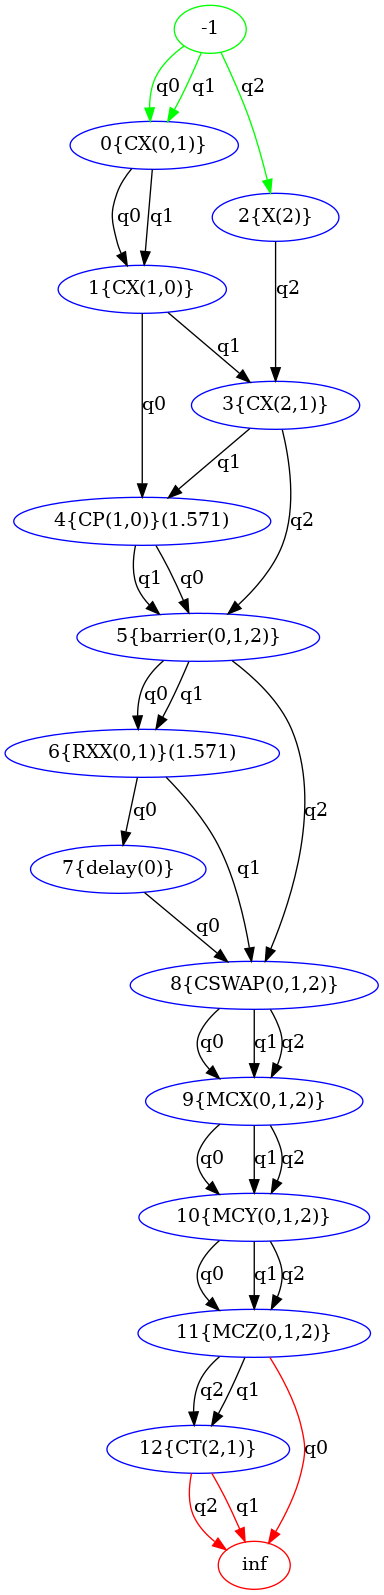

In [10]:
# 创建一个量子电路作为示例，您可以根据需要修改这个电路
simple = QuantumCircuit(3)
simple.measure([2], [1])
simple.cnot(0, 1)
simple.cnot(1, 0)
simple.x(2)
simple.cnot(2, 1)
simple.cp(1, 0,np.pi / 2)
simple.barrier([0, 1, 2])
simple.rxx(0, 1, np.pi / 2)
simple.delay(0, 100)
simple.fredkin(0,1, 2)
simple.mcx([0, 1], 2)
simple.mcy([0, 1], 2)
simple.mcz([0, 1], 2)
simple.ct(2,1)
# simple.measure([0], [0])
# simple.measure([1], [2])
simple.measure([1,2], [1,2])



# 构建dag
dep_graph = circuit_to_dag(simple, measure_flag = False)  #  dag graph

# 可视化dag
draw_dag(dep_graph, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png





# 在此处添加您的其它代码，例如模拟电路，分析结果等

In [11]:
type(dep_graph)

dag_circuit.DAGCircuit

## remove node

In [12]:
dep_graph_copy = copy.deepcopy(dep_graph)
nodes = copy.deepcopy(list(dep_graph_copy.nodes()))
nogate_nodes = [nodes[0],nodes[-2],nodes[-1]]  # -1,inf,measure node
# dep_graph_copy.remove_nodes_from(nogate_nodes)  # remove -1,inf,measure node
# dep_graph_copy.remove_nodes_from([nodes[6]])  # remove -1,inf,measure node

In [13]:
# i = 14
# nodes[i].name, nodes[i].pos, nodes[i].paras, nodes[i].duration, nodes[i].unit,nodes[i].label



In [14]:
# for predecessor in dep_graph_copy.predecessors(nodes[i]):
#     print(predecessor.name, predecessor.pos, predecessor.paras, predecessor.duration, predecessor.unit, predecessor.label)

In [15]:
# for successor in dep_graph_copy.successors(nodes[i]):
#     print(successor.name, successor.pos, successor.paras, successor.duration, successor.unit, successor.label)

In [16]:
# for edge in dep_graph_copy.in_edges(nodes[i], data=True):
#     print(edge[0], edge[1], edge[2])
# predecessor_nodes = [edge[0] for edge in dep_graph_copy.in_edges(nodes[i], data=True)]
# labels = [int(edge[2]['label'][1:]) for edge in dep_graph_copy.in_edges(nodes[i], data=True)]
# labels
# # get a dict about keys are the predecessors of the node and values are the labels of the edges
# predecessor_labels = dict(zip(labels,predecessor_nodes))
# predecessor_labels,predecessor_labels.keys(),predecessor_labels.values()

In [17]:
# successor_nodes = [edge[1] for edge in dep_graph_copy.out_edges(nodes[i], data=True)]
# labels = [int(edge[2]['label'][1:]) for edge in dep_graph_copy.out_edges(nodes[i], data=True)]
# labels
# # get a dict about keys are the successors of the node and values are the labels of the edges
# successor_labels = dict(zip(labels,successor_nodes))
# successor_labels,successor_labels.keys(),successor_labels.values()

In [18]:
# successors = list(dep_graph_copy.successors(nodes[i]))
# predecessors = list(dep_graph_copy.predecessors(nodes[i]))

# # for successor in successors:
# #     self.remove_edge(node, successor)
# #     for predecessor in predecessors:
# #         self.add_edge(predecessor, successor, label=None, color='black')
# # self.remove_node(node)
# for successor in successors:
#     dep_graph_copy.remove_edge(nodes[i], successor)
#     # for predecessor in predecessors:
# for qubit in nodes[i].pos:
#     if predecessor_labels[qubit] != -1 and successor_labels[qubit] != float('inf'):
#         dep_graph_copy.add_edge(predecessor_labels[qubit], successor_labels[qubit], label=f"q{qubit}")
#     elif predecessor_labels[qubit] == -1 and successor_labels[qubit] != float('inf'):
#         dep_graph_copy.add_edge(predecessor_labels[qubit], successor_labels[qubit], label=f"q{qubit}", color='green')
#     else:
#         dep_graph_copy.add_edge(predecessor_labels[qubit], successor_labels[qubit], label=f"q{qubit}", color='red')
# dep_graph_copy.remove_node(nodes[i])


In [19]:
list(dep_graph_copy.nodes(data=True))

[(-1, {'color': 'green'}),
 (0{CX(0,1)}, {'color': 'blue'}),
 (1{CX(1,0)}, {'color': 'blue'}),
 (2{X(2)}, {'color': 'blue'}),
 (3{CX(2,1)}, {'color': 'blue'}),
 (4{CP(1,0)}(1.571), {'color': 'blue'}),
 (5{barrier(0,1,2)}, {'color': 'blue'}),
 (6{RXX(0,1)}(1.571), {'color': 'blue'}),
 (7{delay(0)}, {'color': 'blue'}),
 (8{CSWAP(0,1,2)}, {'color': 'blue'}),
 (9{MCX(0,1,2)}, {'color': 'blue'}),
 (10{MCY(0,1,2)}, {'color': 'blue'}),
 (11{MCZ(0,1,2)}, {'color': 'blue'}),
 (12{CT(2,1)}, {'color': 'blue'}),
 (inf, {'color': 'red'})]

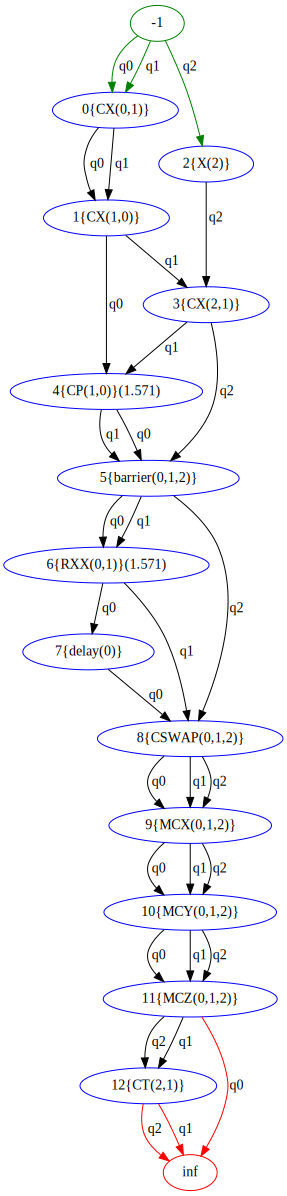

In [20]:
# # get the dag nodes
# nodes = list(dep_graph.nodes(data=True))
# print("dag nodes:", nodes)

# # get the dag edges
# edges = list(dep_graph.edges(data=True))
# print("dag edges:", edges)

draw_dag(dep_graph, output_format="svg")  # 或者使用 "svg" 作为输出格式,默认为png

In [21]:
mynodes_dict = dep_graph_copy.nodes_dict()
mynodes_dict

{0: 0{CX(0,1)},
 2: 2{X(2)},
 1: 1{CX(1,0)},
 3: 3{CX(2,1)},
 4: 4{CP(1,0)}(1.571),
 5: 5{barrier(0,1,2)},
 6: 6{RXX(0,1)}(1.571),
 7: 7{delay(0)},
 8: 8{CSWAP(0,1,2)},
 9: 9{MCX(0,1,2)},
 10: 10{MCY(0,1,2)},
 11: 11{MCZ(0,1,2)},
 12: 12{CT(2,1)}}

In [22]:
dep_graph_copy.remove_instruction_node(mynodes_dict[5])

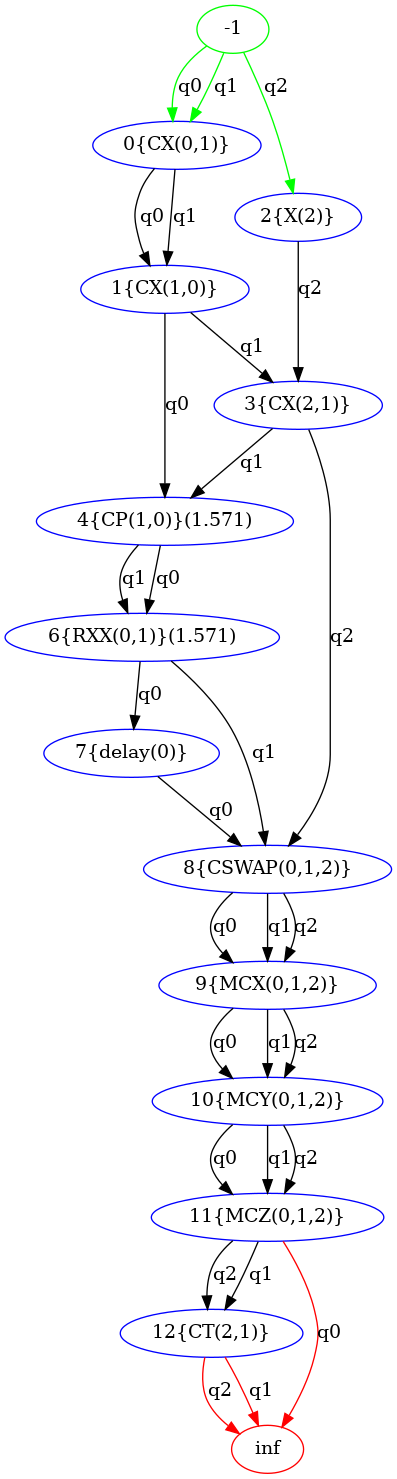

In [23]:
draw_dag(dep_graph_copy, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

In [24]:
dep_graph_copy.qubits_used = dep_graph_copy.update_qubits_used()
dep_graph_copy.qubits_used

{0, 1, 2}

In [25]:
nodes

[-1,
 0{CX(0,1)},
 1{CX(1,0)},
 2{X(2)},
 3{CX(2,1)},
 4{CP(1,0)}(1.571),
 5{barrier(0,1,2)},
 6{RXX(0,1)}(1.571),
 7{delay(0)},
 8{CSWAP(0,1,2)},
 9{MCX(0,1,2)},
 10{MCY(0,1,2)},
 11{MCZ(0,1,2)},
 12{CT(2,1)},
 inf]

## node_dict

In [26]:
dep_graph.nodes_dict() 
dep_graph.nodes_dict()[12]

12{CT(2,1)}

In [27]:
dep_graph.nodes_list()[6]

6{RXX(0,1)}(1.571)

In [28]:
# make a node_dict
node_dict = {}
for node in nodes:
    if node != -1 and node != float('inf'):
        node_dict[node.label] = node

node_dict 
    

{0: 0{CX(0,1)},
 1: 1{CX(1,0)},
 2: 2{X(2)},
 3: 3{CX(2,1)},
 4: 4{CP(1,0)}(1.571),
 5: 5{barrier(0,1,2)},
 6: 6{RXX(0,1)}(1.571),
 7: 7{delay(0)},
 8: 8{CSWAP(0,1,2)},
 9: 9{MCX(0,1,2)},
 10: 10{MCY(0,1,2)},
 11: 11{MCZ(0,1,2)},
 12: 12{CT(2,1)}}

In [29]:
# test the node_dict
node_dict[5]

5{barrier(0,1,2)}

In [30]:
simple.draw_circuit()

q[0]  --*----+---------P(1.571)----||-------#---------Delay(100ns)----*----*----*----*-------
        |    |            |        ||   RXX(1.571)                    |    |    |    |       
q[1]  --+----*----+-------*--------||-------#-------------------------x----*----*----*----T-- M->c[1]
                  |                ||                                 |    |    |    |    |  
q[2]  --X---------*----------------||---------------------------------x----X----Y----Z----*-- M->c[2]


## 计算qubit  used 依据 -1或者inf对应的边的label

In [31]:
# make a qubit_used dict
qubit_used = {}
# 依据 -1或者inf对应的边的label
nodes[0]
for edge in dep_graph_copy.out_edges(nodes[0], data=True):
    print(edge[0], edge[1], edge[2])

qubit_used = set([int(edge[2]['label'][1:]) for edge in dep_graph_copy.out_edges(nodes[0], data=True)])
qubit_used


-1 0{CX(0,1)} {'label': 'q0', 'color': 'green'}
-1 0{CX(0,1)} {'label': 'q1', 'color': 'green'}
-1 2{X(2)} {'label': 'q2', 'color': 'green'}


{0, 1, 2}

In [32]:
dep_graph_copy.update_qubits_used()
type(dep_graph_copy.qubits_used)

set

## dag 拼接

In [33]:
# other circuit to compose
simple2 = QuantumCircuit(4)
simple2.h(2)
simple2.cnot(2, 3)
simple2.cnot(1, 2)

simple2.draw_circuit()

q[0]  --------------- M->c[0]
                     
q[1]  ------------*-- M->c[1]
                  |  
q[2]  --H----*----+-- M->c[2]
             |       
q[3]  -------+------- M->c[3]


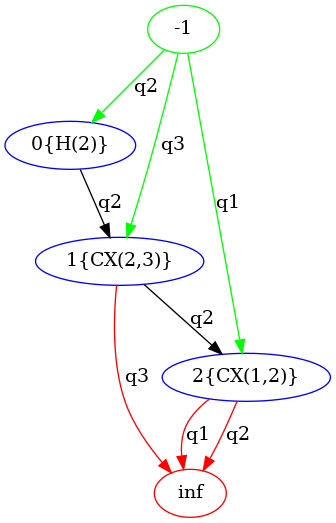

In [34]:
# other dag
other_dag = circuit_to_dag(simple2,measure_flag=False)  #  dag graph

# draw the other dag
draw_dag(other_dag, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

In [35]:
other_dag_copy = copy.deepcopy(other_dag)
nodes_2 = copy.deepcopy(list(other_dag_copy.nodes()))
# nogate_nodes = [nodes[0],nodes[-2],nodes[-1]]  # -1,inf,measure node
# dep_graph_copy.remove_nodes_from(nogate_nodes)  # remove -1,inf,measure node
# dep_graph_copy.remove_nodes_from([nodes[6]])  # remove -1,inf,measure node
nodes_2

[-1, 0{H(2)}, 1{CX(2,3)}, 2{CX(1,2)}, inf]

### -1 node 的边 

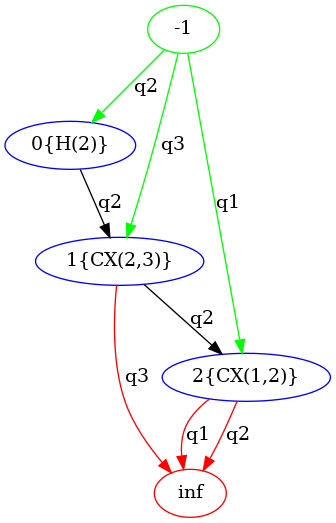

In [36]:
# draw the other dag
draw_dag(other_dag_copy, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

### 拼接

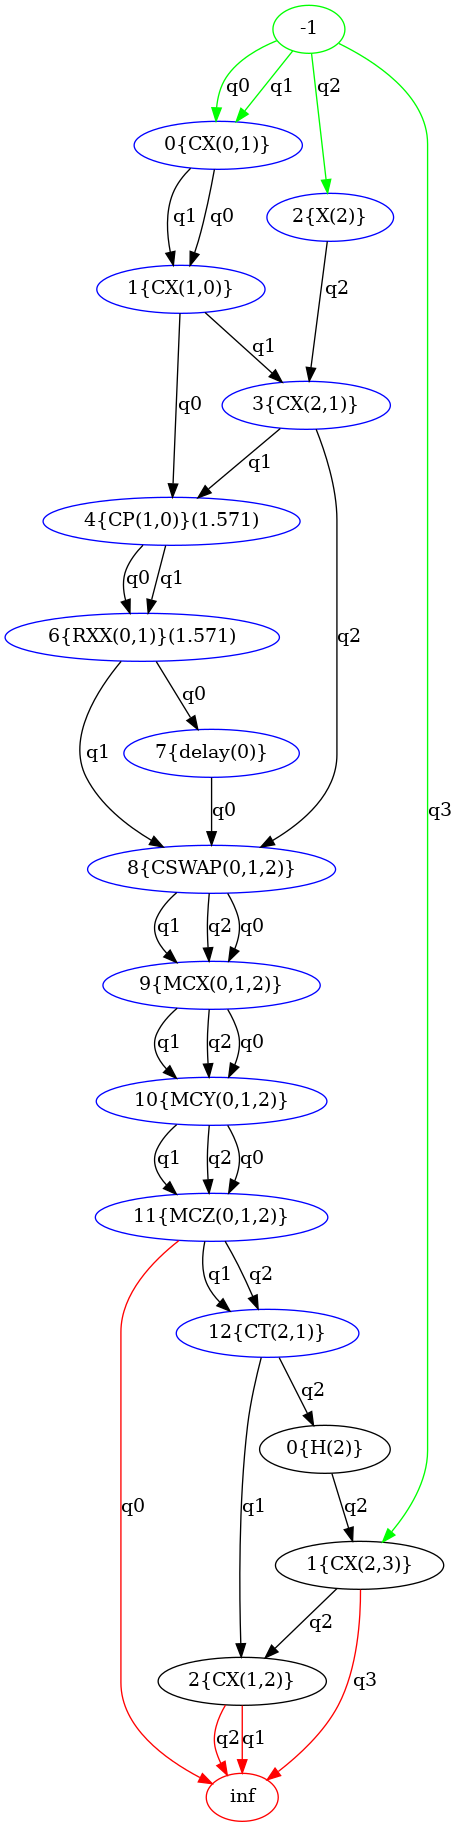

In [37]:
dep_graph_copy.merge_dag(other_dag_copy)
draw_dag(dep_graph_copy, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

In [38]:
dep_graph_copy.qubits_used

{0, 1, 2, 3}

In [39]:
dep_graph_copy.update_cbits_used()
dep_graph_copy.update_num_instruction_nodes()

dep_graph_copy.cbits_used,dep_graph_copy.num_instruction_nodes

(set(), 15)

## add nodes with giving predecessors and successors lists according to the qubits pos
这个 predecesors 和 successors 是按照qubits的位置来的，所以要先求出qubits的位置   
predecessors 和 successors 可以按照dag的nodes的label来求，并且按照the added node的pos也就是qubits来排序后以一个list的形式作为参数传入

In [40]:
# predessors of the added node ,make a list
# for example ,the added node is the barrier node 

# 1. get the added node
# use node_dict to get the added node
the_added_node = node_dict[5]
the_added_node

# 2. get the predessors of the added node
addnode_predessors = copy.deepcopy(list(dep_graph.predecessors(the_added_node)))

# 3. get the successors of the added node
addnode_successors = copy.deepcopy(list(dep_graph.successors(the_added_node)))


addnode_predessors, addnode_successors
#([4{CP(1,0)}(1.571), 3{CX(2,1)}], [6{RXX(0,1)}(1.571), 8{CSWAP(0,1,2)}])

# 4. remove the edges between the predessors,successors about the qubits used by the added node 
# 4.1 get the qubits used by the added node
qubits_used_by_added_node = [qubit for qubit in the_added_node.pos]


# 4.2 make a predessors dict about the qubits 
addnode_predessors_dict = {}
addnode_predessors_dict[0] = addnode_predessors[0]
addnode_predessors_dict[1] = addnode_predessors[0]
addnode_predessors_dict[2] = addnode_predessors[1]


# 4.3 make a successors dict about the qubits
addnode_successors_dict = {}
addnode_successors_dict[0] = addnode_successors[0]
addnode_successors_dict[1] = addnode_successors[0]
addnode_successors_dict[2] = addnode_successors[1]

addnode_predessors_dict, addnode_successors_dict


({0: 4{CP(1,0)}(1.571), 1: 4{CP(1,0)}(1.571), 2: 3{CX(2,1)}},
 {0: 6{RXX(0,1)}(1.571), 1: 6{RXX(0,1)}(1.571), 2: 8{CSWAP(0,1,2)}})

In [41]:
dep_graph_copy.add_instruction_node(the_added_node,addnode_predessors_dict,addnode_successors_dict)

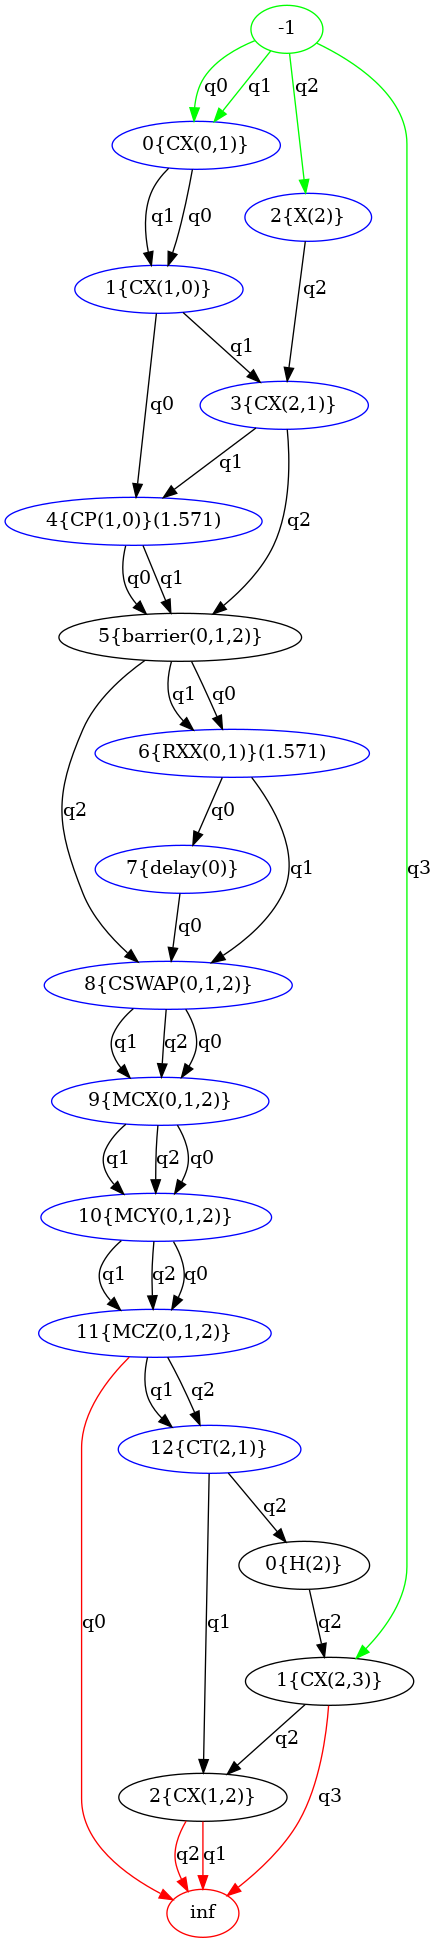

In [42]:
# draw the dep_graph_copy, which is the first dag
draw_dag(dep_graph_copy, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

## relabeling nodes

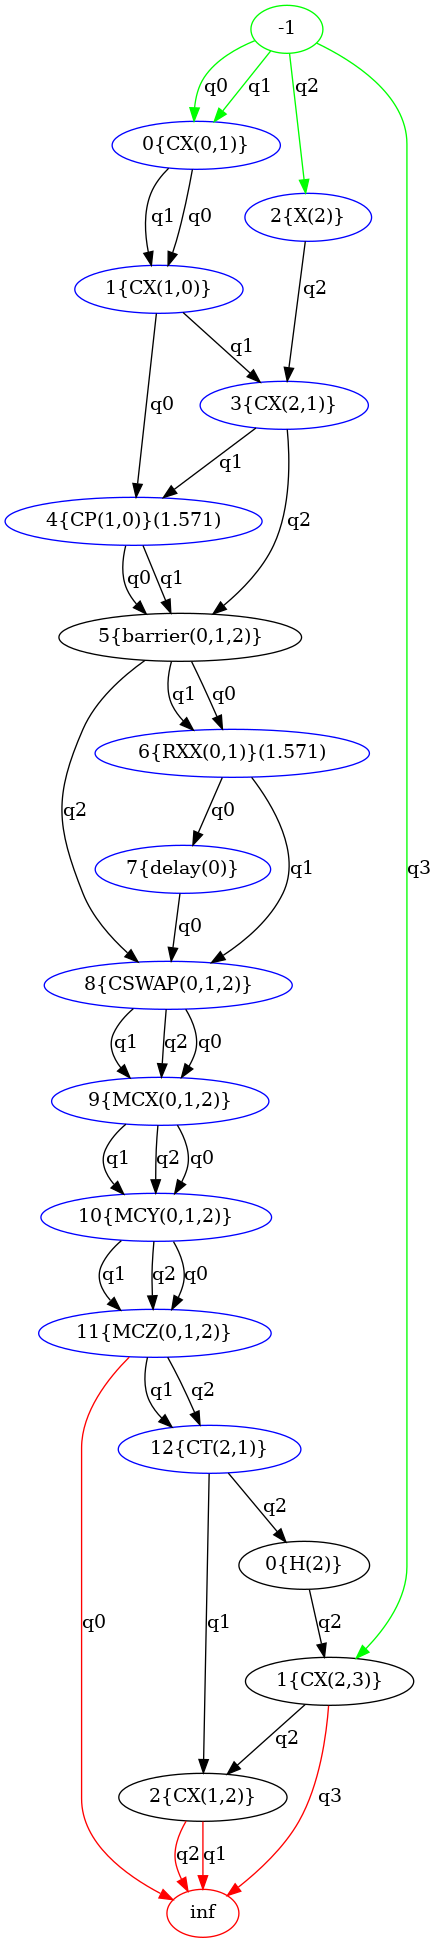

In [43]:
draw_dag(dep_graph_copy, output_format="png") 

In [44]:
# relabel the nodes

dep_graph_copy_copy2 = nx.MultiDiGraph()
dep_graph_copy_copy2.add_nodes_from([(-1, {"color": "green"})])

i = 0
for node in  nx.topological_sort(dep_graph_copy):
    if node not in [-1, float('inf')]:
        node_copy = copy.deepcopy(node)
        node_copy.label = i
        dep_graph_copy_copy2.add_node(node_copy)
        i += 1

dep_graph_copy_copy2.add_nodes_from([(float('inf'), {"color": "red"})])

for edge in dep_graph_copy.edges(data=True):
    dep_graph_copy_copy2.add_edges_from([(edge[0], edge[1], edge[2])])


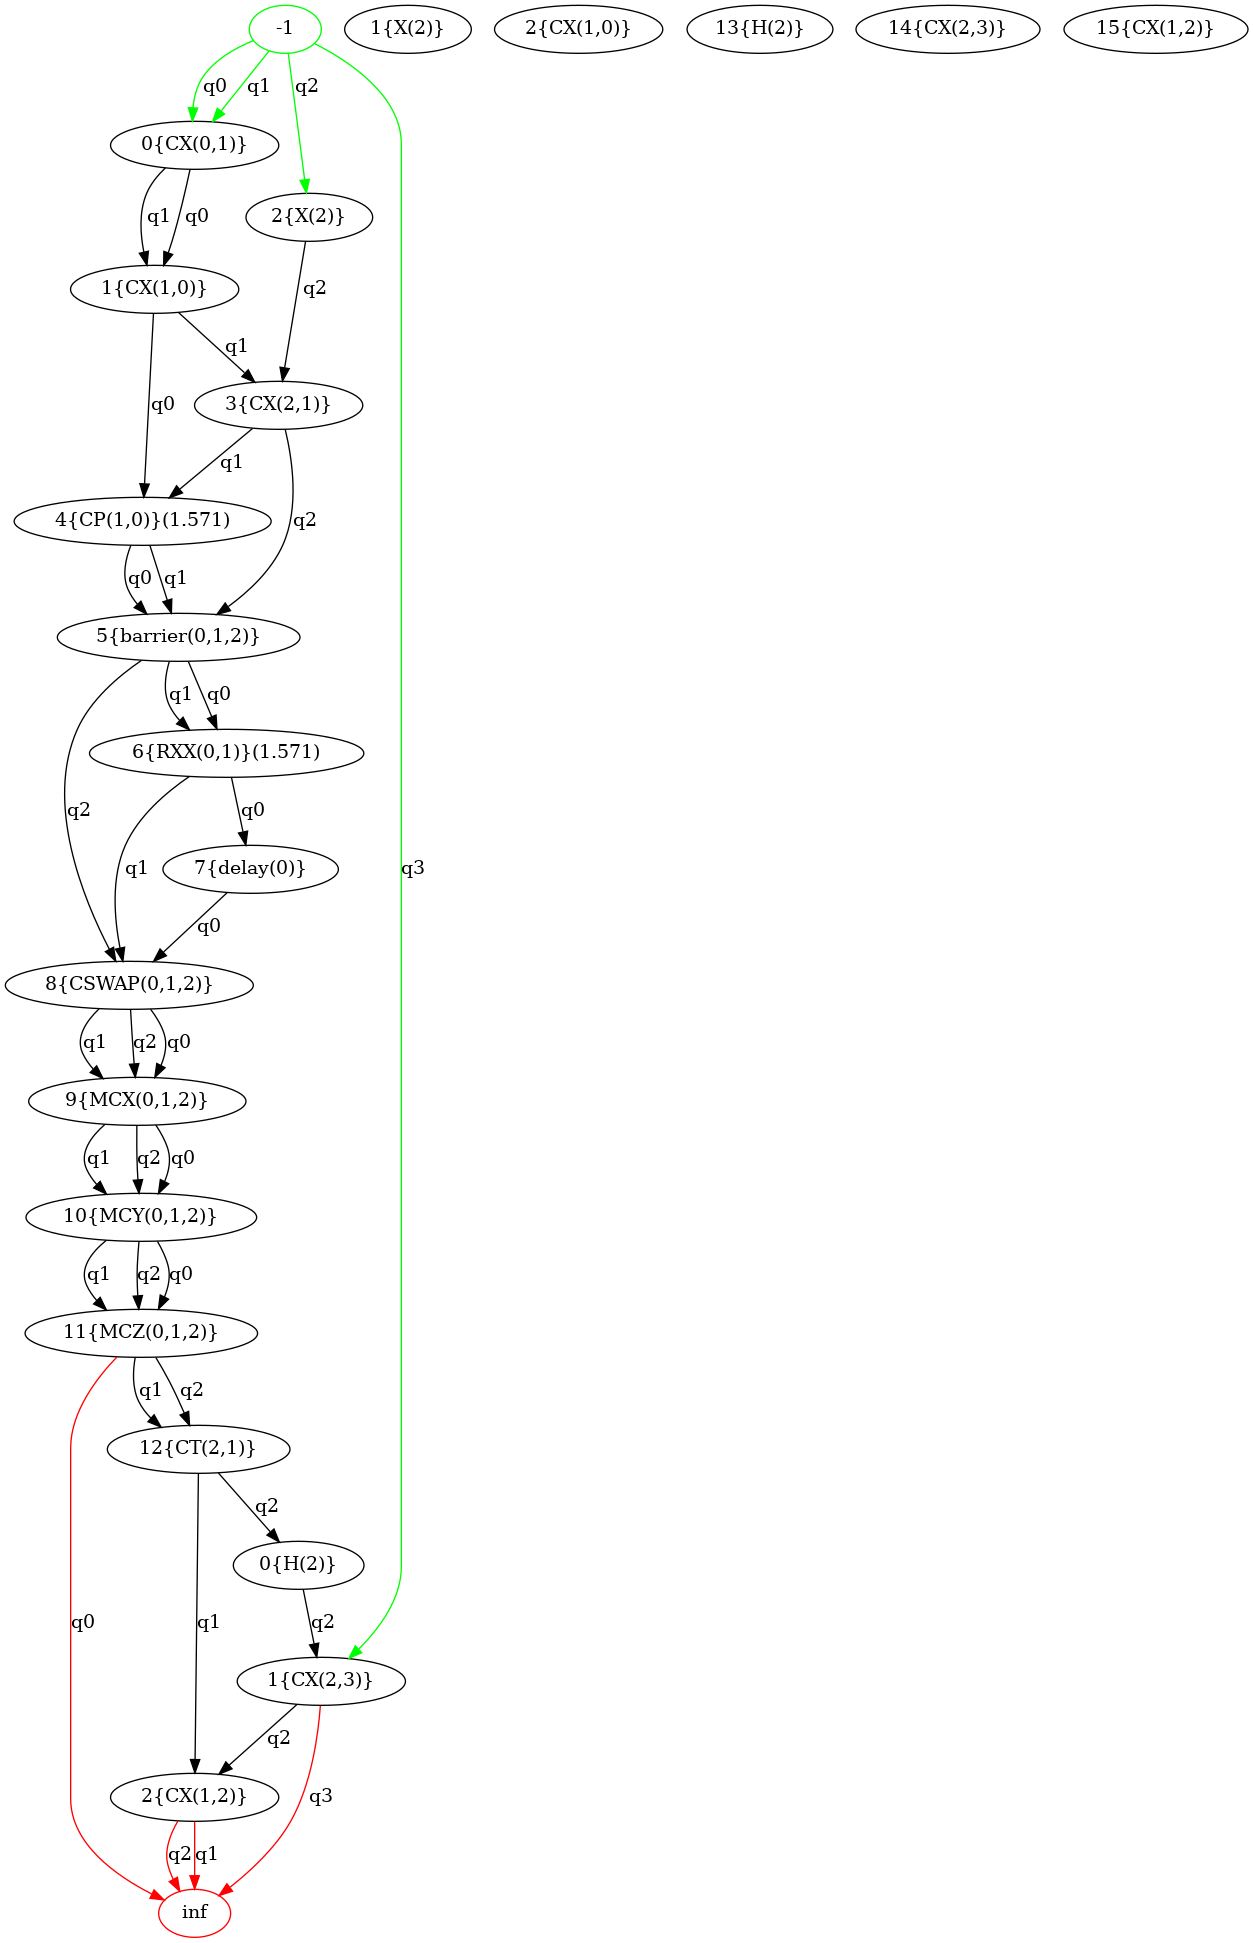

In [45]:
# draw the dep_graph_copy, which is the first dag
draw_dag(dep_graph_copy_copy2, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png


In [46]:
# # relabel by reconstructed_circuit , circuit to dag again
# qubit_num = len(qubit_used | qubit_used_2) # 并集求总的qubit数
# re_circuit = dag_to_circuit(dep_graph_copy, qubit_num)

# # 构建dag
# re_dep_graph = circuit_to_dag(re_circuit,measure_flag= False)  # 更新为新的函数名

# # 可视化dag
# draw_dag(re_dep_graph, output_format="svg")  # 或者使用 "png" 作为输出格式

NameError: name 'qubit_used_2' is not defined

In [47]:
# re_circuit.draw_circuit()

NameError: name 're_circuit' is not defined

## nodelist_to_dag

In [48]:
def nodelist_to_dag(op_nodes: List[Any]) -> DAGCircuit:
    # Starting Label Index
    i = 0
    
    # A dictionary to store the last use of any qubit
    qubit_last_use = {}
    
    # g = nx.MultiDiGraph()  # two nodes can have multiple edges
    # g = nx.DiGraph()   # two nodes can only have one edge
    g = DAGCircuit() 
    
    # Add the start node 
    # g.add_node(-1,{"color": "green"})
    g.add_nodes_from([(-1, {"color": "green"})])
    
    # deepcopy the circuit to avoid modifying the original circuit
    # gates = copy.deepcopy(circuit.gates) # need to import copy
    # change to: gate = copy.deepcopy(input_gate) in gate_to_node()

    for op_node in op_nodes:
        # transform gate to node
        hashable_gate = copy.deepcopy(op_node)
        g.add_node(hashable_gate,color="blue")
        
        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.pos:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate,label=f'q{qubit}')
            else:
                g.add_edge(-1, hashable_gate,label=f'q{qubit}',color="green")
            
            qubit_last_use[qubit] = hashable_gate

            
    # Add the end node
    # g.add_node(float('inf'),{"color": "red"})
    g.add_nodes_from([(float('inf'), {"color": "red"})])
    
    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'),label=f'q{qubit}',color="red")

    # update the  qubits_used, cbits_used, num_instruction_nodes
    g.qubits_used = g.update_qubits_used()
    g.cbits_used = g.update_cbits_used()
    g.num_instruction_nodes = g.update_num_instruction_nodes()
    
    return g

In [49]:
# example simple3 circuit
simple3 = QuantumCircuit(3)
simple3.h(0)
simple3.h(1)
simple3.x(2)
simple3.cnot(2,1)
simple3.measure([2,1], [1,2])

simple3.draw_circuit()

q[0]  --H-------
                
q[1]  --H----+-- M->c[2]
             |  
q[2]  --X----*-- M->c[1]


In [50]:
i = 0 
op_nodes = []  
for gate in simple3.gates:
    op_nodes.append(gate_to_node(gate,specific_label=i))
    i += 1

op_nodes



[0{H(0)}, 1{H(1)}, 2{X(2)}, 3{CX(2,1)}]

In [51]:

nodesdag = nodelist_to_dag(op_nodes[1:])

In [52]:
nodes_list = nodesdag.nodes_list()
nodes_list

[1{H(1)}, 2{X(2)}, 3{CX(2,1)}]

In [53]:
# # Add measure_gate node
qm = Any
qm.name = "measure"  
qm.paras, qm.duration, qm.unit = [None,None,None]
qm.pos = copy.deepcopy(simple3.measures)  # circuit.measures is a dict
measure_gate = InstructionNode(qm.name, qm.pos, qm.paras, qm.duration, qm.unit, label="m")
# nodes_list.append(measure_gate)
# nodes_list

In [54]:
for qubit in measure_gate.pos:
    print(qubit)

set(measure_gate.pos),type(measure_gate.pos.keys())

2
1


({1, 2}, dict_keys)

In [55]:
nodesdag.qubits_used

{1, 2}

## nodes_list qubit mapping

In [56]:
# nodes_qubit_mapping_dict 
def nodelist_qubit_mapping_dict(nodes_list):
    '''
    Args:
        nodes_list: a list of nodes
    Returns:
        nodes_qubit_mapping_dict: a dict about keys are the qubits used by the nodes and values are the new qubits
    '''
    nodes_list_qubits_used = set()
    for node in nodes_list:
        if hasattr(node, 'pos') and node.pos is not None:
            nodes_list_qubits_used = nodes_list_qubits_used | set(node.pos)
    
    mapping_pos = list(range(len(nodes_list_qubits_used)))  
    # mapping, get a dict
    nodes_qubit_mapping_dict = dict(zip(sorted(list(nodes_list_qubits_used)), mapping_pos))
    nodes_qubit_mapping_dict

    return nodes_qubit_mapping_dict

def nodelist_qubit_mapping_dict_reverse(nodes_list):
    '''
    Args:
        nodes_list: a list of nodes
    Returns:
        nodes_qubit_mapping_dict_reverse: a dict about keys are the new qubits and values are the qubits used by the nodes
    ''' 
    nodes_qubit_mapping_dict = nodelist_qubit_mapping_dict(nodes_list)
    # reverse mapping, get a dict
    nodes_qubit_mapping_dict_reverse = {value: key for key, value in nodes_qubit_mapping_dict.items()}
     
    return nodes_qubit_mapping_dict_reverse


In [57]:
# a function to map nodes_list
def nodes_list_mapping(nodes_list, nodes_qubit_mapping_dict):
    '''
    Args:
        nodes_list: the nodes list of instruction nodes
        nodes_qubit_mapping_dict: the dict of the mapping qubits

    return: 
        nodes_list_mapping: the nodes_list after mapping qubits
    '''
    nodes_qubit_mapping_dict 
    nodes_list_mapping = []
    for node in nodes_list:
        node_new = copy.deepcopy(node)
        if hasattr(node, 'pos') and node.pos is not None:
            if isinstance(node.pos, list):
                node_new.pos = [nodes_qubit_mapping_dict[qubit] for qubit in node.pos]
            elif isinstance(node.pos, dict):
                node_new.pos = {}
                # the values of the dict are void, so we need to copy the values from the original dict
                for qubit in node.pos:
                    node_new.pos[nodes_qubit_mapping_dict[qubit]] = copy.deepcopy(node.pos[qubit])
        nodes_list_mapping.append(node_new)
    return nodes_list_mapping


In [58]:
nodes_qubit_mapping_dict = nodelist_qubit_mapping_dict(nodes_list)
nodes_qubit_mapping_dict_reverse = nodelist_qubit_mapping_dict_reverse(nodes_list)

mapped_nodes_list = nodes_list_mapping(nodes_list, nodes_qubit_mapping_dict)


mapped_nodes_list_reverse = nodes_list_mapping(mapped_nodes_list, nodes_qubit_mapping_dict_reverse)
# nodes_list,mapped_nodes_list,mapped_nodes_list_reverse
print("original nodes_list:\n", nodes_list)
print("mapped nodes_list:\n", mapped_nodes_list)
print("mapped nodes_list_reverse:\n", mapped_nodes_list_reverse)



original nodes_list:
 [1{H(1)}, 2{X(2)}, 3{CX(2,1)}]
mapped nodes_list:
 [1{H(0)}, 2{X(1)}, 3{CX(1,0)}]
mapped nodes_list_reverse:
 [1{H(1)}, 2{X(2)}, 3{CX(2,1)}]


### nodes_list to dag for qubit mapping
- original nodes_list to dag
- new nodes_list after qubit mapping to dag
- new nodes_list after qubit inverse mapping to dag

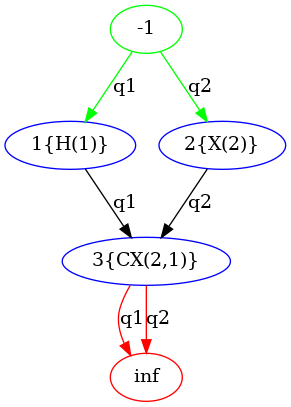

In [59]:
# draw the nodesdag, which is the original dag
nodesdag = nodelist_to_dag(nodes_list)
draw_dag(nodesdag, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

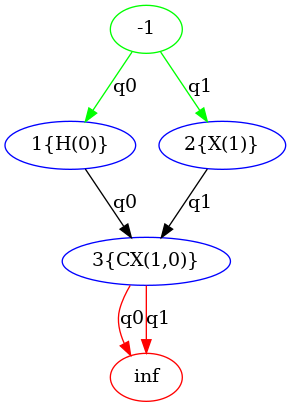

In [60]:
# draw the nodesdag
nodesdag = nodelist_to_dag(mapped_nodes_list)
draw_dag(nodesdag, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

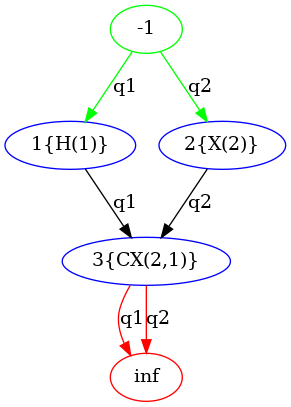

In [61]:
# draw the nodesdag
nodesdag = nodelist_to_dag(mapped_nodes_list_reverse)
draw_dag(nodesdag, output_format="png")  # 或者使用 "svg" 作为输出格式,默认为png

# 2. Transforming DAG to QuantumCircuit

In [62]:
dep_graph.nodes

NodeView((-1, 0{CX(0,1)}, 1{CX(1,0)}, 2{X(2)}, 3{CX(2,1)}, 4{CP(1,0)}(1.571), 5{barrier(0,1,2)}, 6{RXX(0,1)}(1.571), 7{delay(0)}, 8{CSWAP(0,1,2)}, 9{MCX(0,1,2)}, 10{MCY(0,1,2)}, 11{MCZ(0,1,2)}, 12{CT(2,1)}, inf))

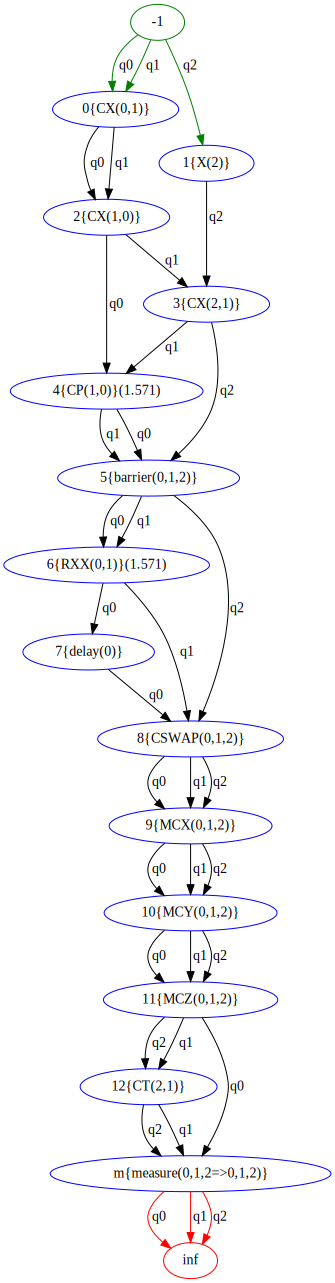

In [63]:
# 从dag中重建量子电路
reconstructed_circuit = dag_to_circuit(dep_graph, simple.num)  # 更新为新的函数名

# 构建dag
dep_graph = circuit_to_dag(reconstructed_circuit)  # 更新为新的函数名

# 可视化dag
draw_dag(dep_graph, output_format="svg")  # 或者使用 "png" 作为输出格式

In [64]:
reconstructed_circuit.draw_circuit()

q[0]  --*----+---------P(1.571)----||-------#---------Delay(100ns)----*----*----*----*------- M->c[0]
        |    |            |        ||   RXX(1.571)                    |    |    |    |       
q[1]  --+----*----+-------*--------||-------#-------------------------x----*----*----*----T-- M->c[1]
                  |                ||                                 |    |    |    |    |  
q[2]  --X---------*----------------||---------------------------------x----X----Y----Z----*-- M->c[2]


In [65]:
edge = {'label': 'q23'}
int(edge['label'][1:]) == 23

True

In [66]:
from quafu import QuantumCircuit